<a href="https://colab.research.google.com/github/Baldezo313/Some-real-world-machine-learning-project/blob/main/PROJET_3_MODELISATION_DU_RISQUE_DE_CREDIT_(MODELE_DE_SCORING).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJET 3 : MODELISATION DU RISQUE DE CREDIT (MODELE DE SCORING)  

**COMPREHENSION DU PROBLEME**  
Lorsqu'une banque prête de l'argent à une personne, elle prend le risque que cette dernière ne
rembourse pas cet argent dans le délai convenu. Ce risque est appelé Risque de Crédit. Alors
avant d'octroyer un crédit, les banques vérifient si le client (ou la cliente) qui demandent un prêt
sera capable ou pas de le rembourser. Cette vérification se fait grâce à l'analyse de plusieurs
paramètres tels que les revenus, les biens, les dépenses actuelles du client, etc. Cette analyse est
effectuée manuellement par plusieurs banques. Ainsi, elle est très consommatrice en temps et
en ressources financières.  

Grâce au Machine Learning, il est possible d'automatiser cette tâche. Dans ce projet, nous allons
construire un algorithme capable de prédire si une personne sera en défaut de paiement ou pas
(1 : défaut, 0 : non-défaut). Nous sommes donc face à un problème de classification car nous
voulons prédire une variable discrète (binaire pour être précis).  

**LIBRAIRIES**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

**DONNEES**  
Deux (02) types de données peuvent être utilisés pour modéliser la probabilité de défaut de paiement :  
* Données liées à la demande de crédit ;  
* Données comportementales décrivant le bénéficiaire du prêt.  

Dans la pratique, les banques utilisent un mélange de ces deux types de données pour construire leur modèle de scoring appliqué au risque de crédit.  
Commençons par l'importation des données :

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Baldezo313/Some-real-world-machine-learning-project/refs/heads/main/Machine-Learning-par-la-pratique-avec-Python-master/data_credit.txt?token=GHSAT0AAAAAAC4VKTEQJYFPNK3DPBPQGTUAZ4GG3LA')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
# Informations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


L'ensemble des données comporte 12 variables et 32581 observations (lignes) historiques.
Chaque observation correspond à une personne ayant contracté un prêt. On a des variables qui
décrivent le crédit (montant, statut, taux d'intérêt, etc.) et d'autres variables qui décrivent la
personne ayant contracté ce crédit (âge, revenu, etc.). Nous allons donc utiliser ces données
historiques afin de construire le modèle de scoring qui va prédire le statut des nouveaux
candidats à un crédit.  


Il est très important de comprendre les variables de notre jeu de données :  
* person_age : variable indiquant l'âge de la personne ;  
* person_income : variable indiquant les revenus (ou encore le salaire) de la personne ;  
* person_home_ownership : variable indiquant le statut de la personne par rapport à son lieu d'habitation (propriétaire, locataire, etc.) ;  
* person_emp_length : variable indiquant la durée (en mois) depuis laquelle la personne est en activité professionnelle ;  
* loan_intent : variable indiquant le motif du crédit ;  
* loan_grade : variable indiquant le grade du prêt ;  
* loan_amnt : variable indiquant le montant du prêt ;  
* loan_int_rate : variable indiquant le taux d'intérêt du rédit ;  
* loan_status : c'est la variable d'intérêt. Elle indique si la personne est en défaut de paiement (1) ou pas (0) ;  
* loan_percent_income : variable indiquant le pourcentage des revenus par rapport au crédit ;  
* cb_person_default_on_file : variable indiquant si la personne ait à découvert ou pas ;  
* cb_person_cred_hist_length : variable indiquant la durée des antécédents de crédits.  


Passons à présent à l'analyse exploratoire des données qui nous permettra de mieux les
comprendre.

## ANALYSE EXPLORATOIRE DES DONNEES

In [4]:
# Résumé statistique des données
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


Nous remarquons que les moyennes et les écart-types sont très différents d'une variable à une
autre. Cela indique que les données ne sont pas à la même échelle. Selon l’algorithme que nous utiliserons, il faudra probablement normaliser les données avant de les modéliser. En effet,
certains algorithmes de Machine Learning nécessitent une normalisation des données pour un
meilleur résultat.  

Une manière très rapide de visualiser les distributions des variables ainsi que les nuages de
points est d'utiliser la fonction pairplot() de Seaborn :

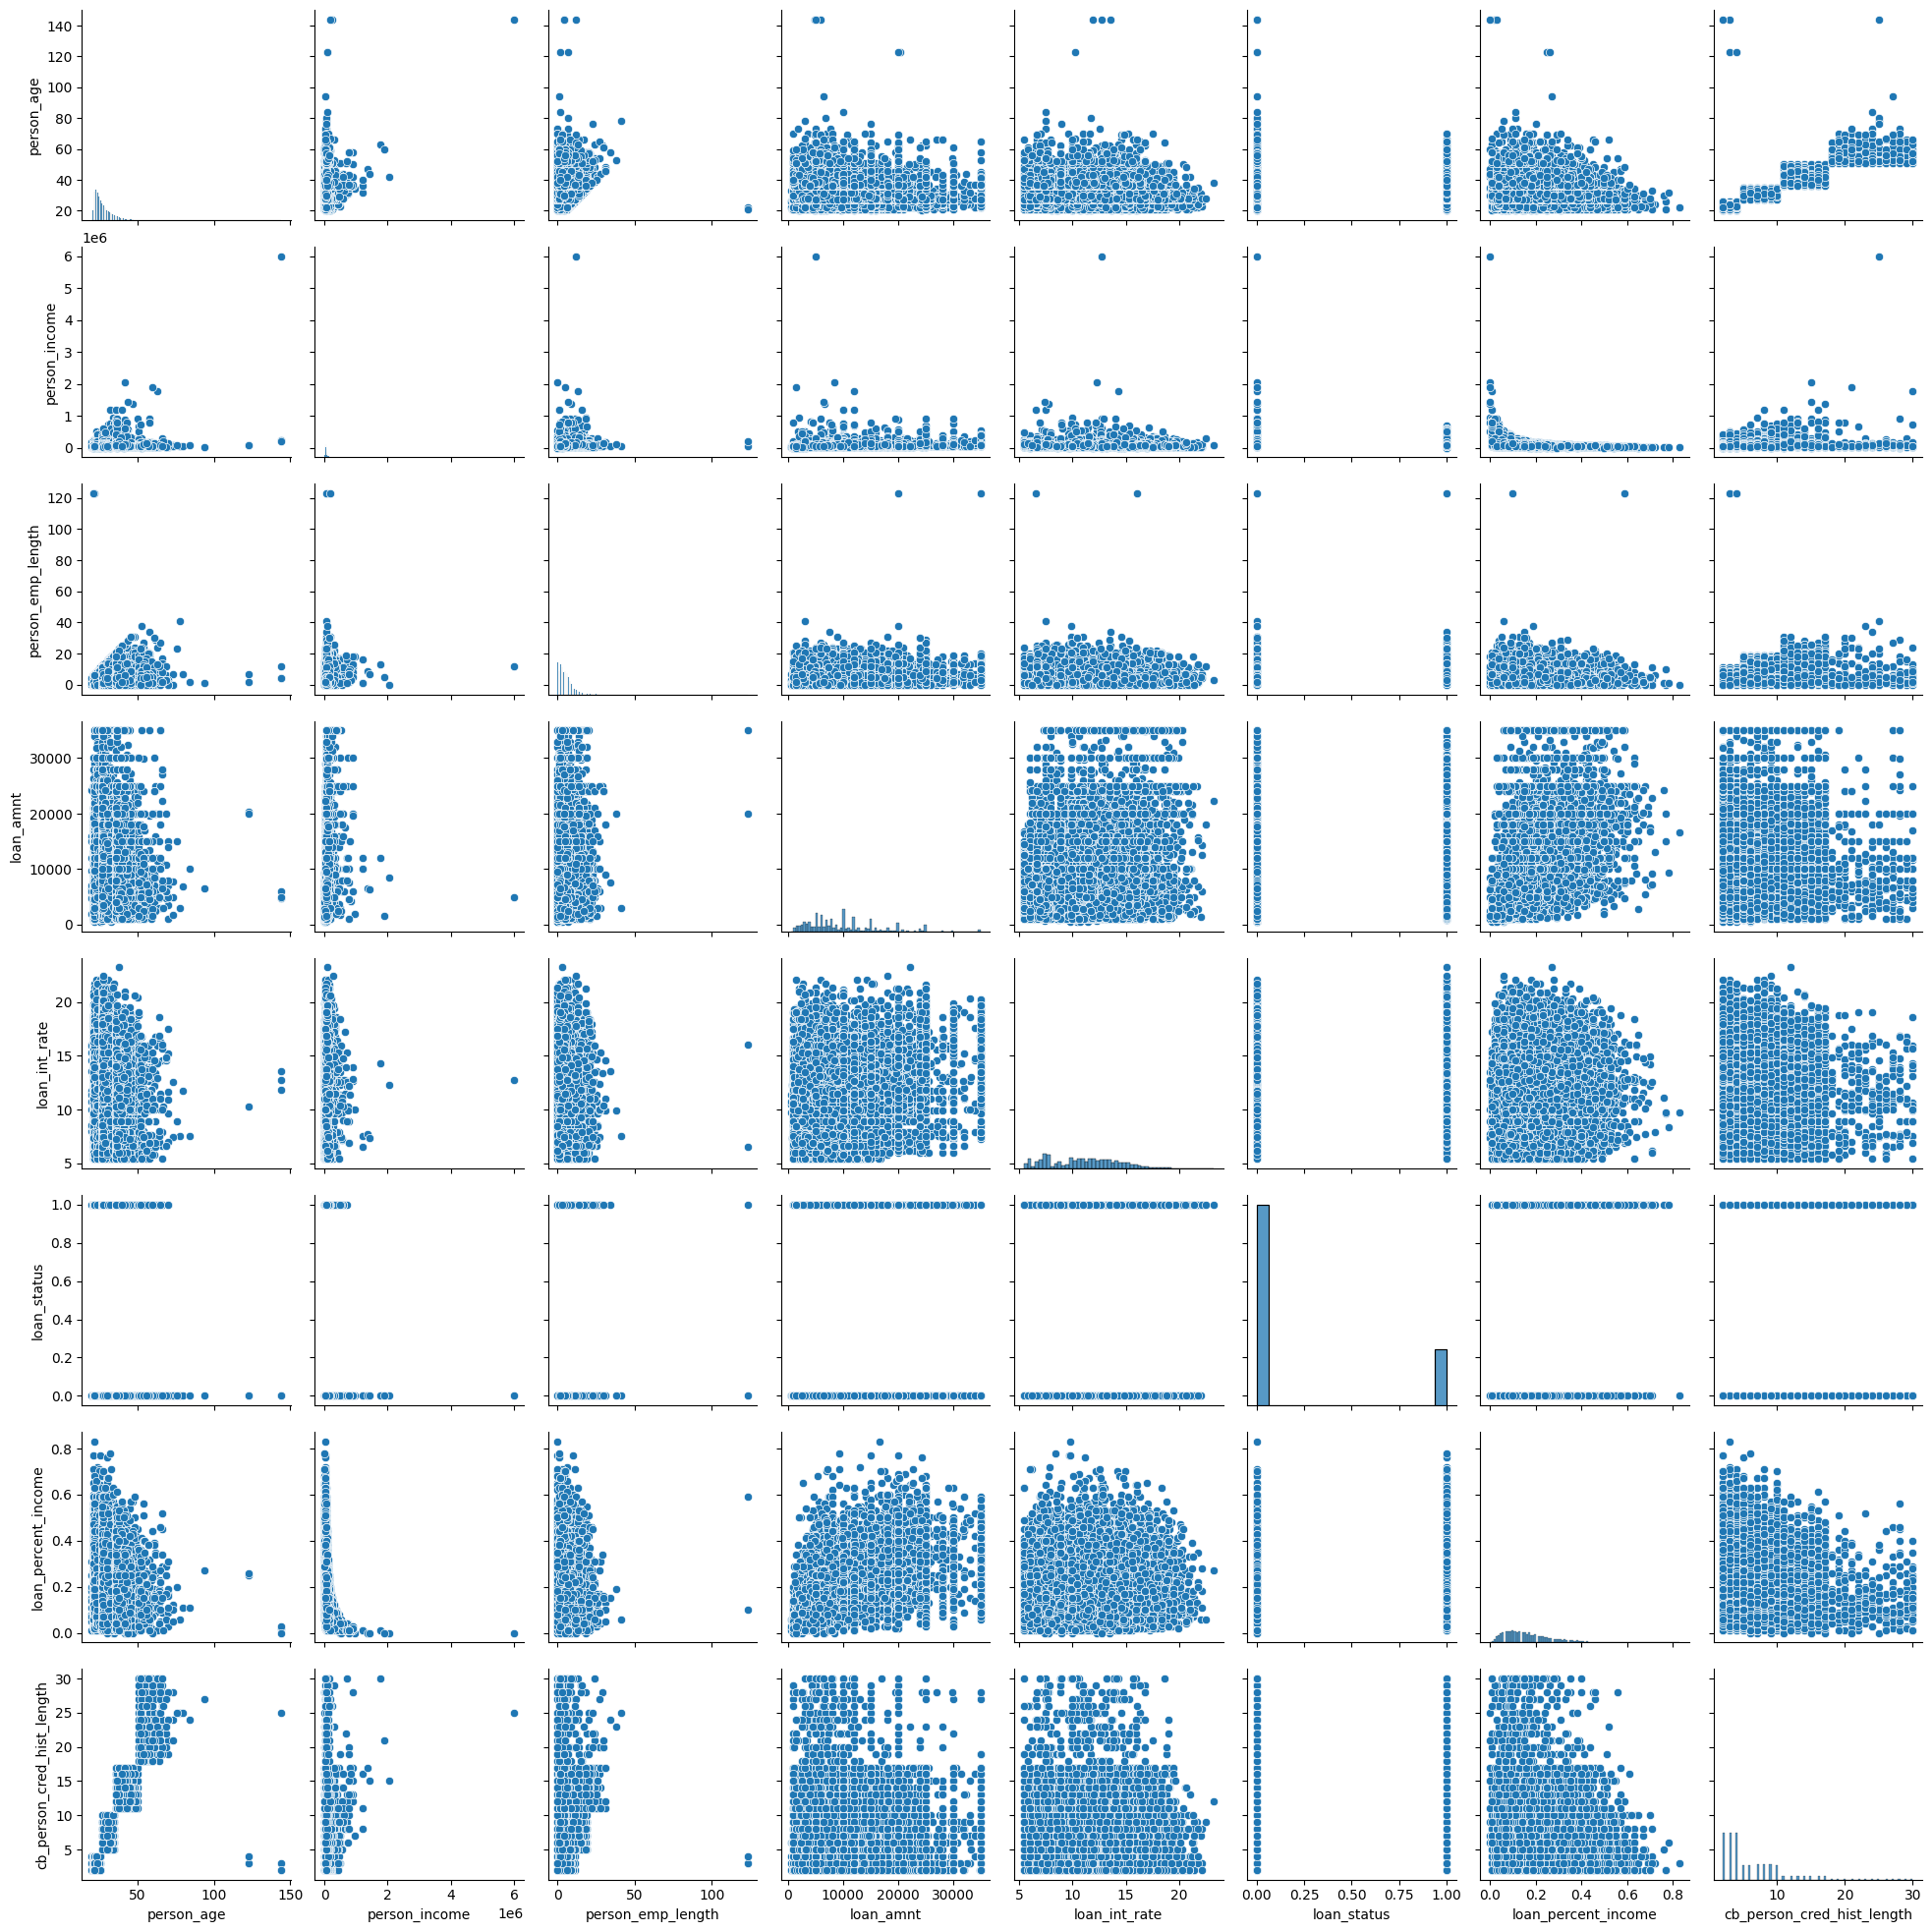

In [5]:
# Distribution des variables et nuages de points
sns.pairplot(df)
plt.show()

Nous pouvons mieux visualiser les histogrammes avec la fonction displot() de Seaborn :

<ipython-input-8-2ecebf4237a7>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['loan_amnt'])


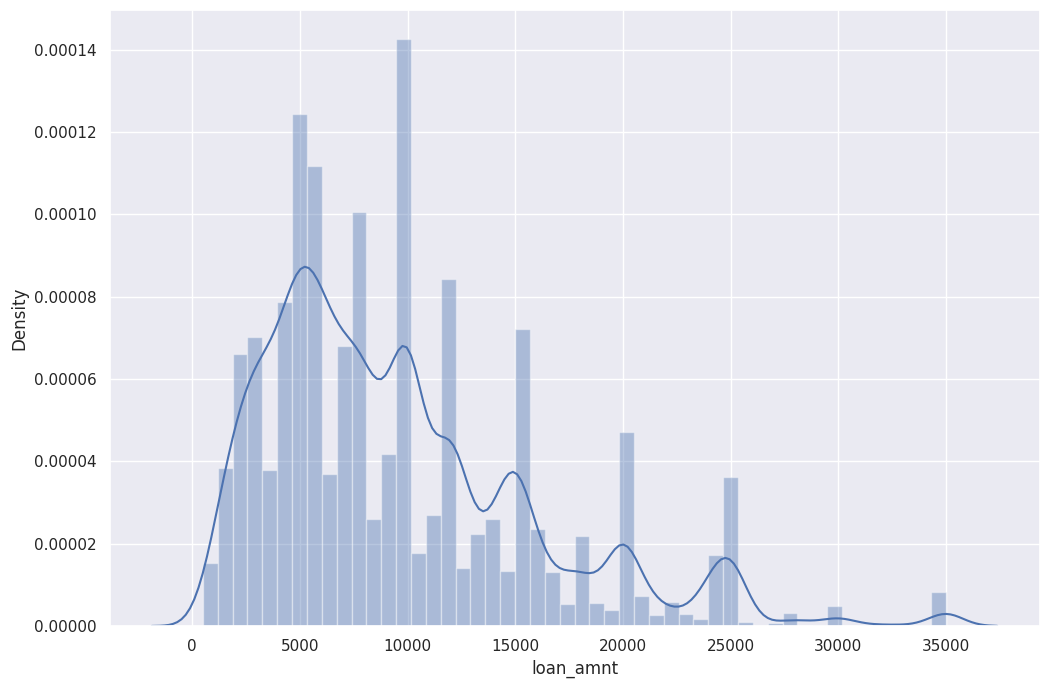

In [8]:
# Distribution de la variable 'loan_amnt'
sns.set(rc={'figure.figsize':(12,8)})
sns.distplot(df['loan_amnt'])
plt.show()

In [10]:
# Coefficients d'asymétrie
# Calculate skewness only for numerical columns
numerical_df = df.select_dtypes(include=np.number)
skewness = numerical_df.skew()

In [11]:
skewness

,0
person_age,2.581393
person_income,32.865349
person_emp_length,2.614455
loan_amnt,1.192477
loan_int_rate,0.208550
loan_status,1.364888
loan_percent_income,1.064669
cb_person_cred_hist_length,1.661790


Le coefficient de la variable person_income est très élevé. Pour corriger cela, faisons une
transformation logarithmique de cette variable :

In [12]:
# Transformation log de la variable 'person_income'
df['person_income'] = np.log(df['person_income'])
# Coefficient d'asymétrie de la variable transformée
df['person_income'].skew()

0.1559408016162584

Voilà qui est bien mieux !  

Traçons à présent le nuage des points des revenus en fonction de l'âge :

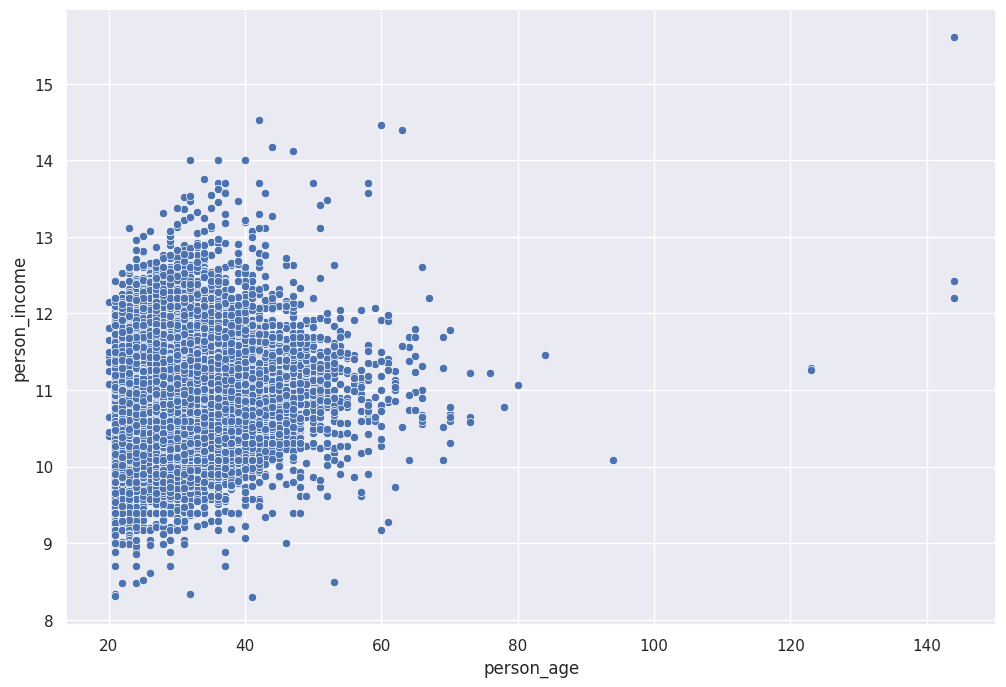

In [13]:
# Pour tracer un nuage de point
sns.set(rc={'figure.figsize':(12,8)})
sns.scatterplot(x='person_age', y='person_income', data=df) # Revenu en fonction de l'âge
plt.show()

Le graphique ci-dessus nous montre qu'il y une très faible corrélation positive entre les revenus
et l'âge. Nous remarquons aussi des outliers (ce sont les valeurs 'aberrantes', c'est-à-dire des
valeurs qui sortent du lot).  

Analysons à présent la fréquence des modalités de chaque variable catégorielle :

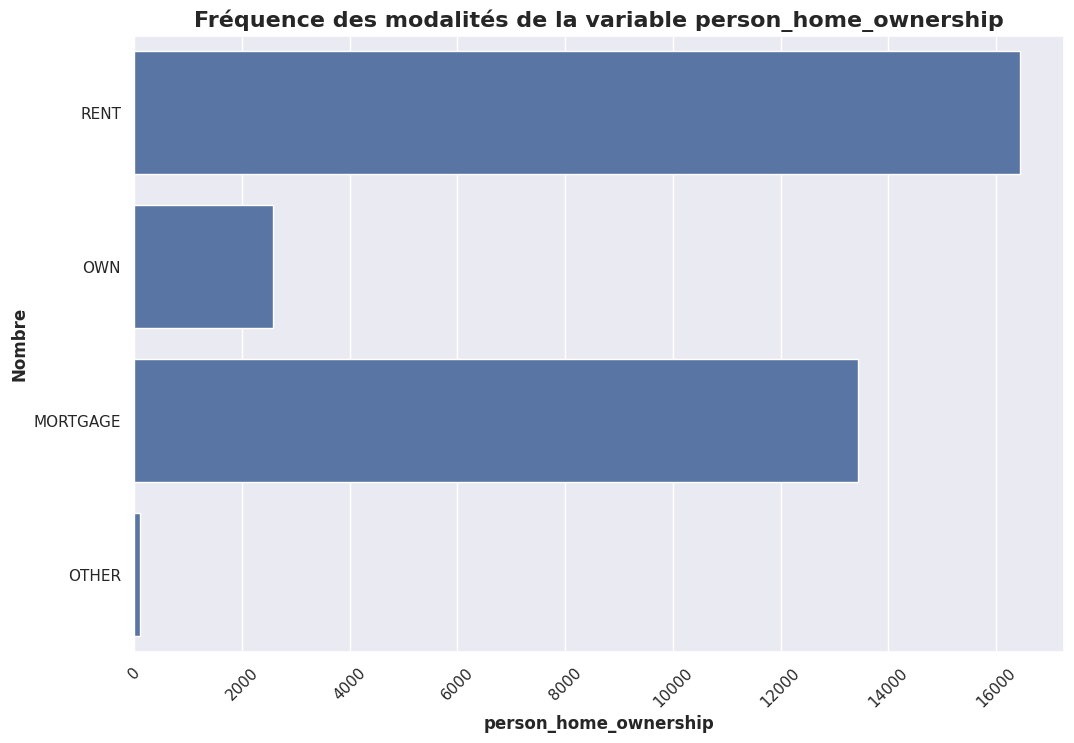

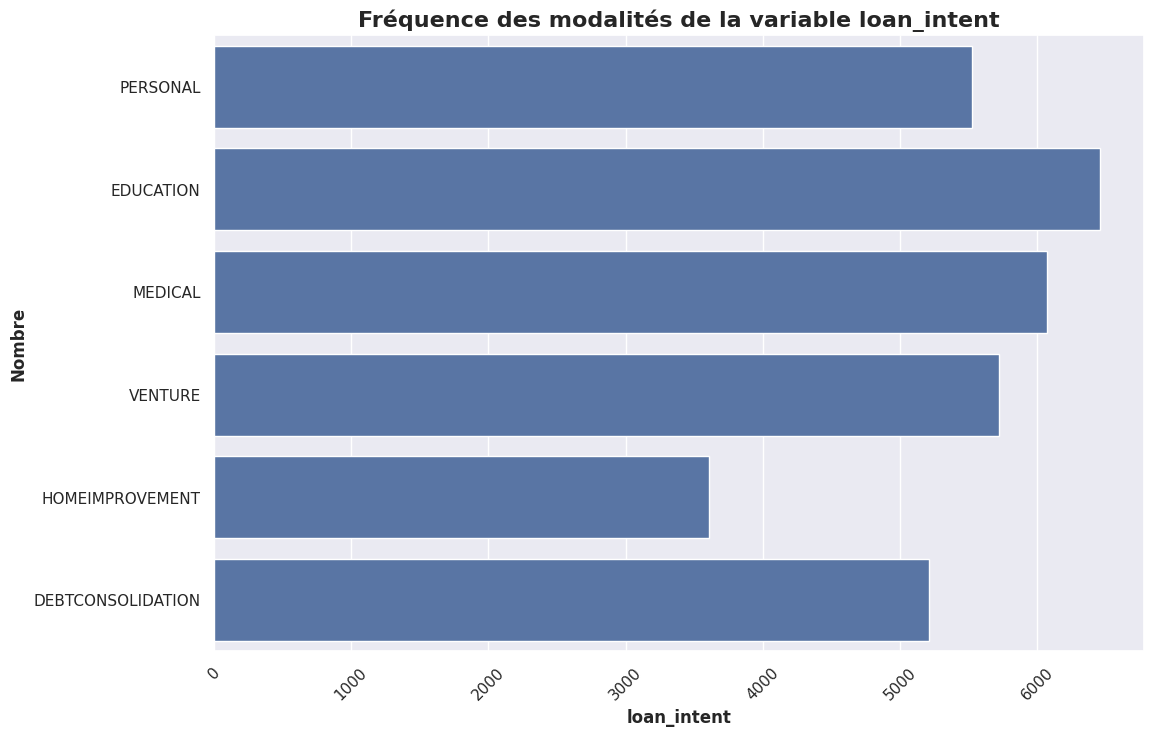

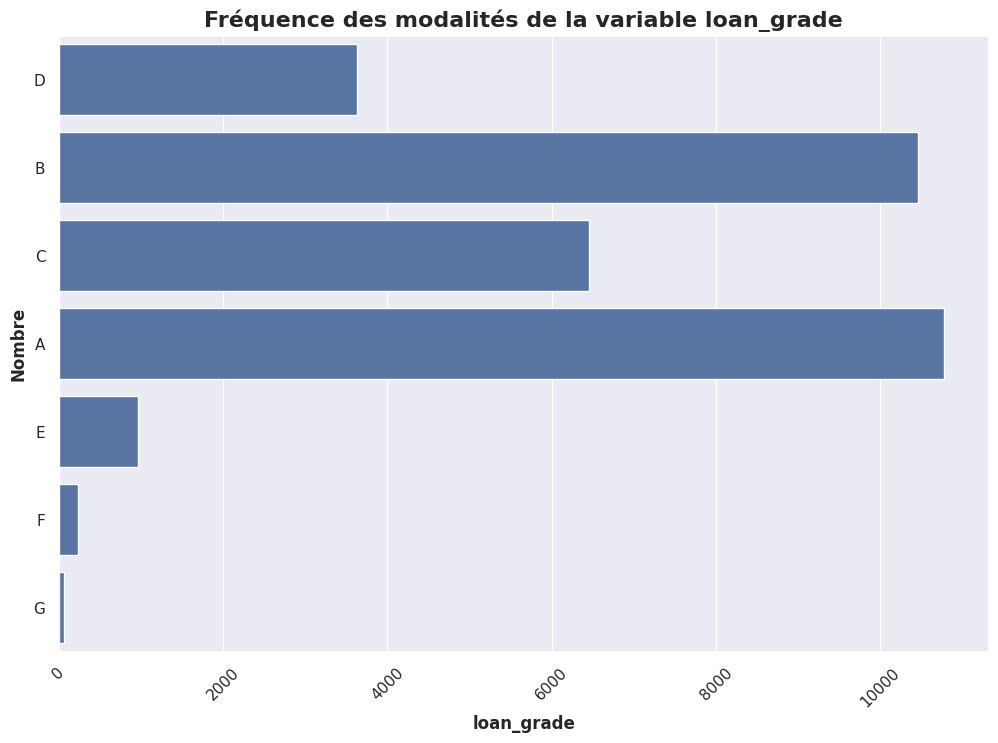

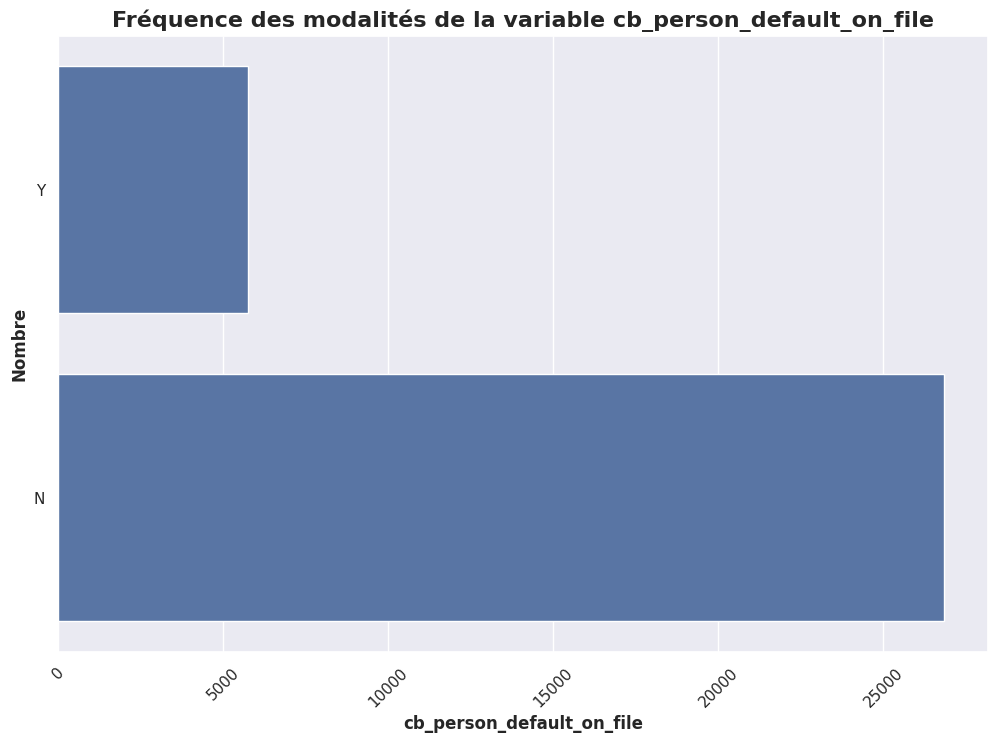

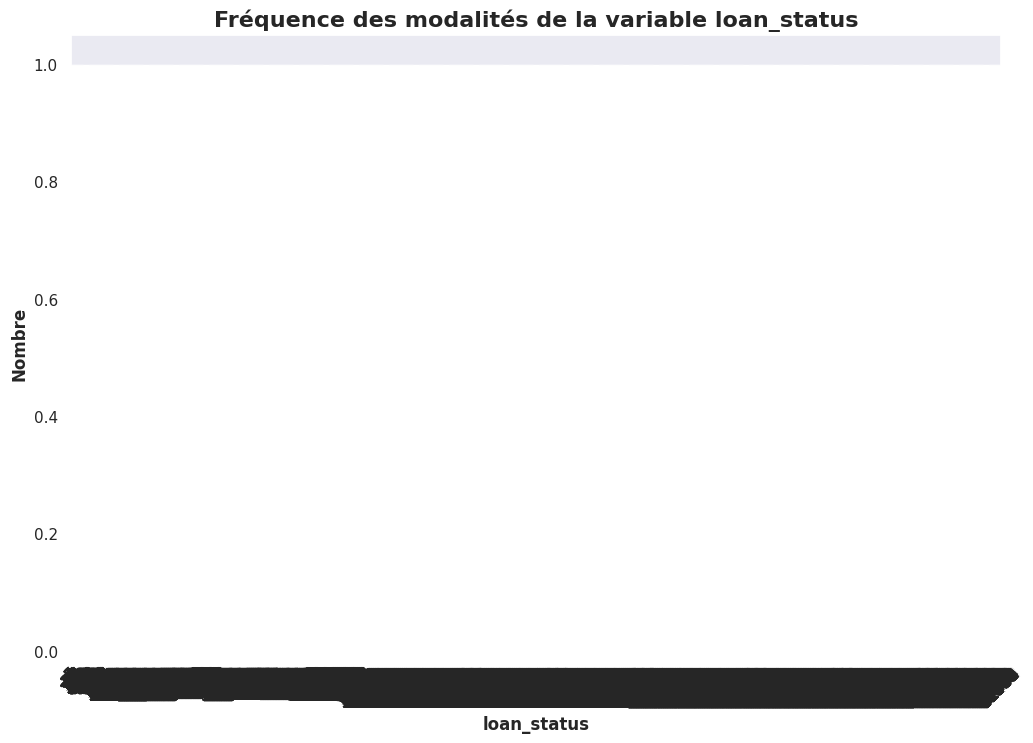

In [14]:

# Faisons une boucle for pour construire un diagamme à barre pour toutes les variables qualitatives
for col in df.select_dtypes(include=['object']).columns.to_list() + ['loan_status']:
  sns.countplot(df[col])
  plt.xlabel(col, fontweight="bold")
  plt.ylabel('Nombre', fontweight="bold")
  plt.xticks(rotation = 45)
  plt.title('Fréquence des modalités de la variable ' + str(col), fontsize=16, fontweight="bold")
  plt.show()
  print('\n')

Nous remarquons un déséquilibre de classe au niveau de la variable d'intérêt (loan_statut). Il y
a beaucoup plus de personnes qui n'ont pas été en défaut de paiement que de personnes en défaut
de paiement. Ce problème peut impacter la qualité de notre modèle car ce dernier pourrait avoir
tendance à prédire que tous les nouveaux demandeurs de prêts ne seront pas en défaut de
paiement. Ceci causerait d'énormes pertes d'argent à la banque. Il existe plusieurs méthodes
pour traiter les problèmes de déséquilibre de classe. Nous utiliserons l'une de ces méthodes dans
la partie prétraitement des données avant la modélisation.  

Très souvent, les données financières sont souvent analysées avec des tableaux croisés
dynamiques comme dans Excel. Construisons alors quelques tableaux croisés dynamiques :

In [15]:
# Tableau croisé dynamique entre le motif de prêt et le statut du prêt
pd.crosstab(df["loan_intent"], df["loan_status"], margins = True)

loan_status,0,1,All
loan_intent,,,
DEBTCONSOLIDATION,3722,1490,5212
EDUCATION,5342,1111,6453
HOMEIMPROVEMENT,2664,941,3605
MEDICAL,4450,1621,6071
PERSONAL,4423,1098,5521
VENTURE,4872,847,5719
All,25473,7108,32581


In [16]:
# Tableau croisé dynamique de l'accès à la propriété groupé par le statut ainsi que le grade du crédit
pd.crosstab(df["person_home_ownership"],[df["loan_status"],df["loan_grade"]])

loan_status               0                                 1             \
loan_grade                A     B     C    D    E   F  G    A     B    C   
person_home_ownership                                                      
MORTGAGE               5219  3729  1934  658  178  36  0  239   324  321   
OTHER                    23    29    11    9    2   0  0    3     5    6   
OWN                     860   770   464  264   26   7  0   66    34   31   
RENT                   3602  4222  2710  554  137  28  1  765  1338  981   

loan_status                               
loan_grade                D    E   F   G  
person_home_ownership                     
MORTGAGE                553  161  61  31  
OTHER                    11    6   2   0  
OWN                      18   31   8   5  
RENT                   1559  423  99  27

In [17]:
# Tableau croisé dynamique du % moyen du revenu par rapport aumontant du prêt groupé par les variables "person_home_ownership" et 'loan_status'
pd.crosstab(df['person_home_ownership'], df['loan_status'], values=df['loan_percent_income'], aggfunc='mean')

loan_status,0,1
person_home_ownership,,
MORTGAGE,0.146504,0.184882
OTHER,0.143784,0.300000
OWN,0.180013,0.297358
RENT,0.144611,0.264859


Par exemple, le revenu de ceux qui ont leur propre maison (donc les propriétaires) et qui sont
en défaut de paiement est égal en moyenne à 29,73% du montant de leur crédit.

Quelle est la relation entre le pourcentage du revenu et le statut du crédit ?

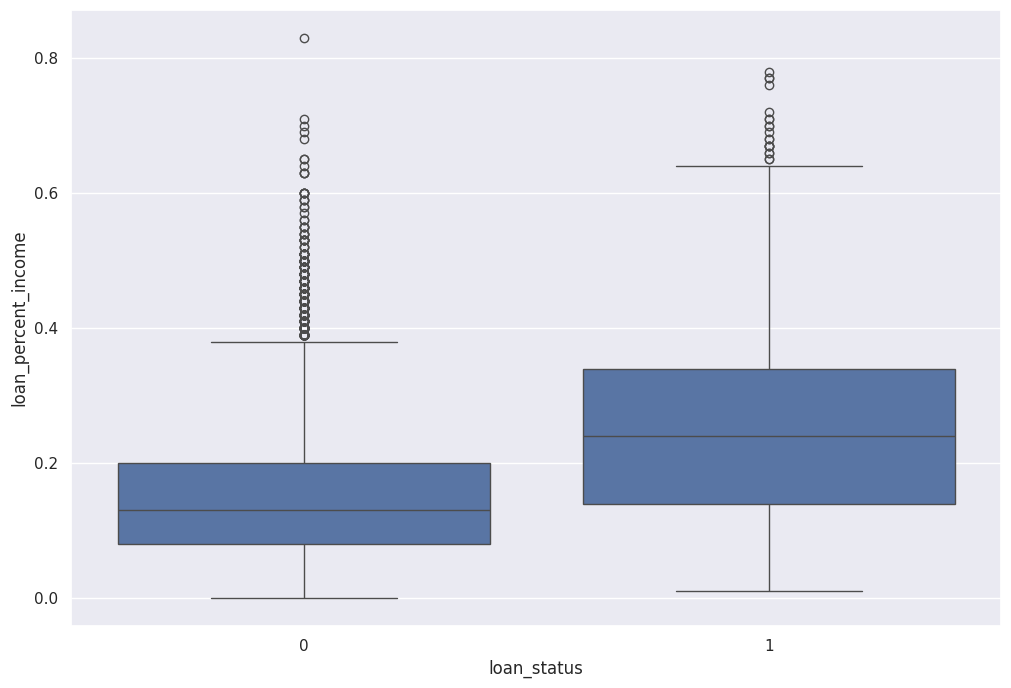

In [18]:
sns.boxplot(x='loan_status', y='loan_percent_income', data=df)
plt.show()

Selon ce graphique, le pourcentage moyen de revenu (par rapport au montant du prêt) pour les
personnes en défaut de paiement est plus élevé. Cela indique que ces bénéficiaires ont un ratio dette / revenu déjà trop élevé. En effet, lorsque le ratio dette / revenu est très important, cela veut dire tout simplement que le crédit est trop élevé par rapport aux revenus de la personne. Et lorsqu'on a un crédit trop élevé par rapport à ses revenus, le risque d'être en défaut de paiement est logiquement et naturellement élevé.  

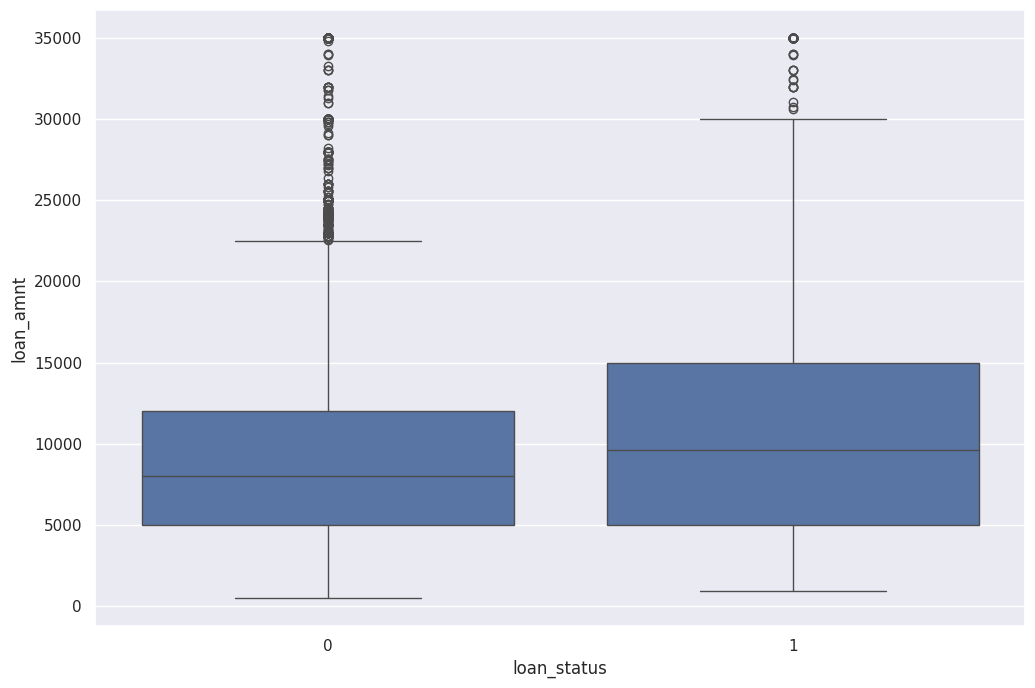

In [19]:
# loan_amnt vs loan_status
sns.boxplot(x='loan_status', y='loan_amnt', data=df)
plt.show()

Globalement, les personnes en défaut de paiement ont un crédit supérieur à celui des personnes
qui ont remboursé leurs prêts.

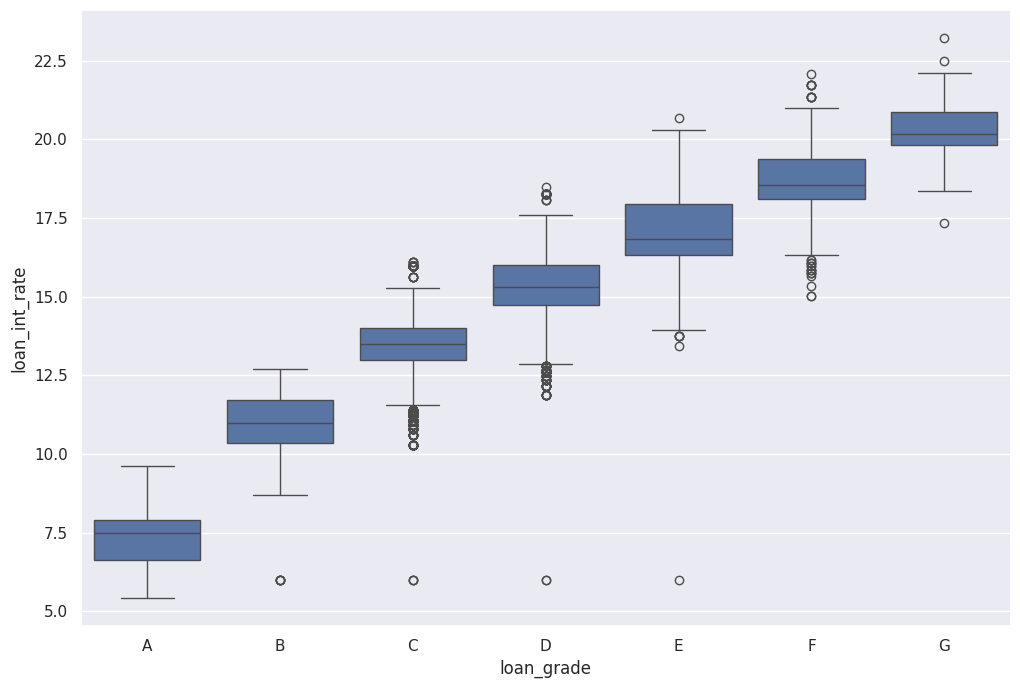

In [20]:
# loan_int_rate vs loan_grade
credit_grade = ["A", "B", "C", "D", "E", "F", "G"]
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x='loan_grade', y='loan_int_rate', data=df, order=credit_grade)
plt.show()

Plus le crédit est important (grade élevé), plus le taux d'intérêt est élevé.  

Construisons le même graphique sans les outliers pour voir si on la même tendance:

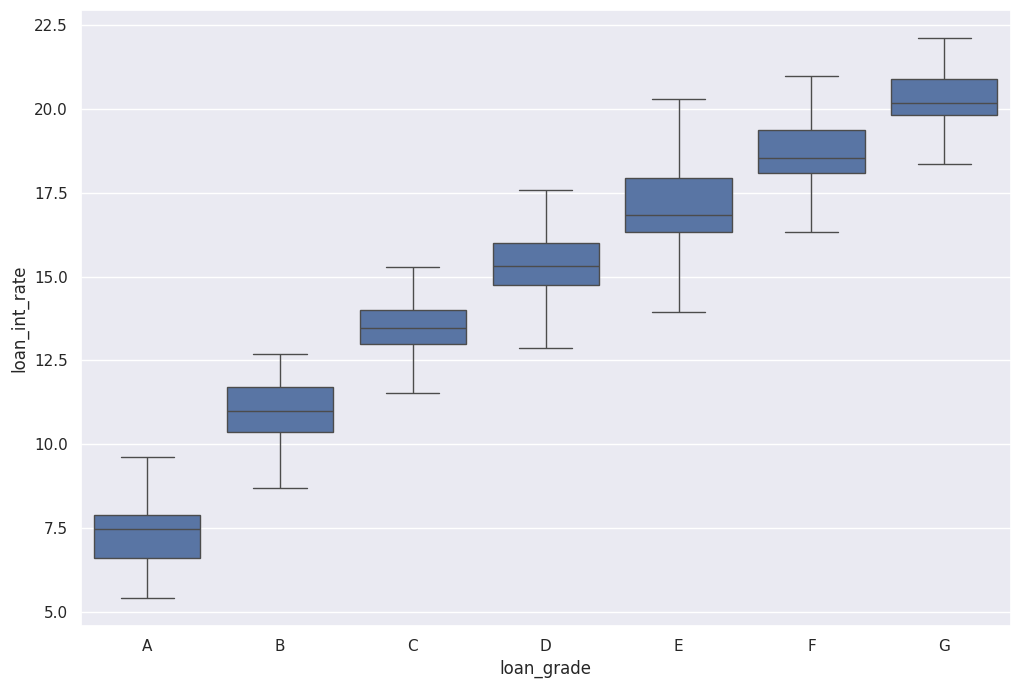

In [22]:
# Même graphique sans les outliers
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x='loan_grade', y='loan_int_rate', showfliers=False, data=df, order=credit_grade)
plt.show()

* **CORRELATIONS**

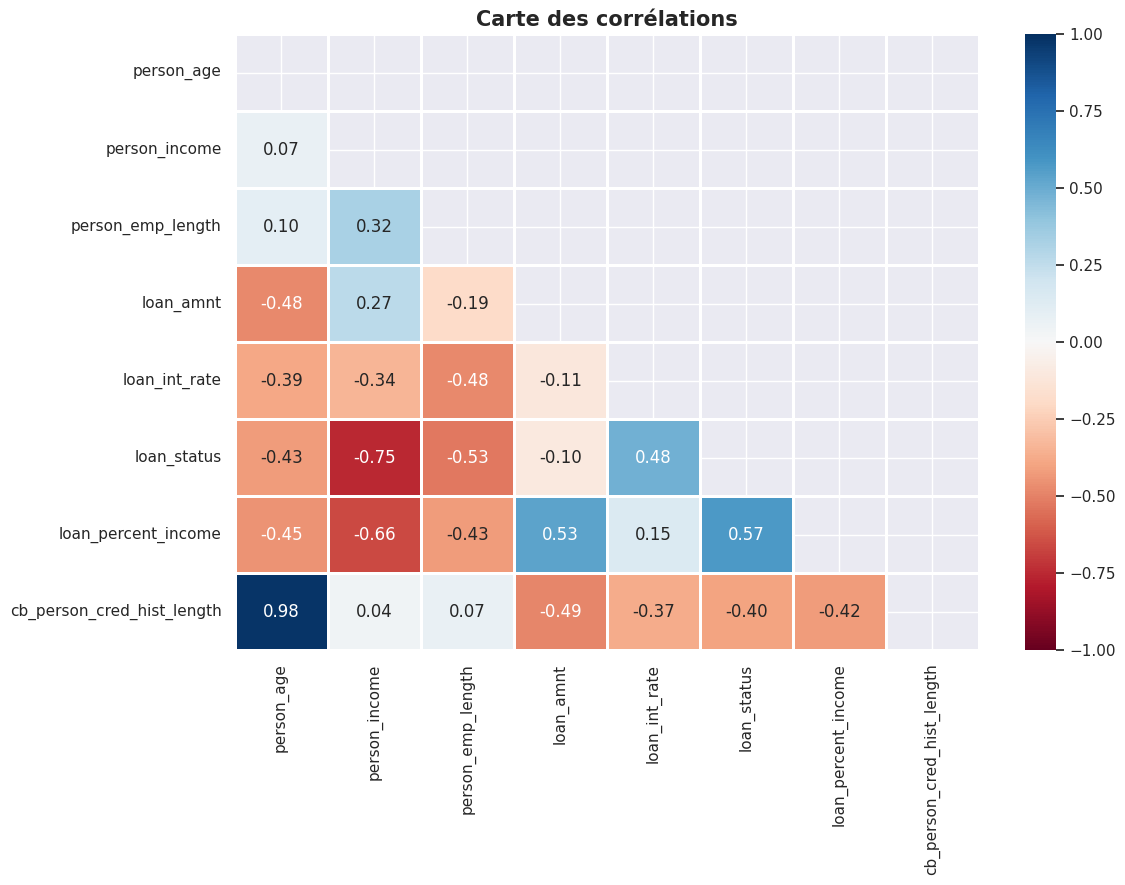

In [23]:
# Carte des corrélations
mask = np.triu(np.ones_like(df.select_dtypes(exclude=['object']).corr(), dtype=bool))
sns.heatmap(df.select_dtypes(exclude=['object']).corr().corr(), mask=mask, center=0, cmap='RdBu', linewidths=1, annot=True,
fmt=".2f", vmin=-1, vmax=1)
plt.title('Carte des corrélations', fontsize=15, fontweight="bold")
plt.show()

**NETTOYAGE DES DONNEES**  
Lors de l'analyse exploratoire des données, nous avons remarqué la présence d'outliers. Ces
valeurs aberrantes peuvent affecter la qualité d'un modèle de Machine Learning. Nous allons
donc les retirer des données.  


Avant de retirer les outliers, il faut d'abord les détecter. L'analyse exploratoire nous a permis de
savoir que cette banque avait par exemple des client(e)s de plus de 100 ans, même de plus de
140 ans. Nous pouvons utiliser le 'bon sens' pour dire qu'il est très peu probable qu'une personne
qui demande un crédit ait plus de 100 ans. Ainsi on supprimerait toutes les lignes où la variable
person_age a des valeurs supérieures à 100.  

Il existe aussi des méthodes statistiques, plus ou moins rigoureuses, pour détecter les outliers.
Nous utiliserons l’une de ces méthodes à savoir l’inter-quartile.

* **METHODE DE DETECTION DES VALEURS ABERRANTES BASEE SUR
L'INTER-QUARTILE (IQR)**  

Selon cette méthode, une valeur est aberrante si elle est inférieure à Q1−1.5IQR ou supérieure
à Q3+1.5IQR. A partir de cette définition, créons une définition de détection des outliers :

In [24]:
def detection_outliers_by_iqr(y):
  Q1, Q3 = np.quantile(y, 0.25), np.quantile(y, 0.75)
  iqr = Q3 - Q1
  borne_inf = Q1 - iqr * 1.5
  borne_sup = Q3 + iqr * 1.5
  return np.where((y > borne_sup) | (y < borne_inf))

* **SUPPRESSION DES OUTLIERS**

In [25]:
# Application de la fonction detection_outliers_by_iqr()
indices_outliers_age = detection_outliers_by_iqr(df['person_age'])
print(indices_outliers_age)
print(type(indices_outliers_age))

(array([   81,   183,   575, ..., 32578, 32579, 32580]),)
<class 'tuple'>


Nous avons un tuple contenant un tableau Numpy donnant les indices de lignes des valeurs
aberrantes de la variable person_age détectées par la fonction detection_outliers_by_iqr()
précédemment créée. Nous allons maintenant supprimer ces observations (lignes) :  

In [26]:
print("le sahpe avant suppression", df.shape)
df.drop(indices_outliers_age[0], inplace=True) # Le tableau numpy est le premier élément du tuple (donc d'indice 0)
df.shape


le sahpe avant suppression (32581, 12)


(31087, 12)

En supprimant les outliers, l'ensemble des données est passé de 32580 à 31087 observations.

* **En supprimant les outliers, l'ensemble des données est passé de 32580 à 31087 observations.**

In [27]:
# Nombre de valeurs manquantes par colonne
df.isna().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,861
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,2953
loan_status,0
loan_percent_income,0


Il existe deux principales techniques pour traiter les valeurs manquantes :  
* Suppression des lignes contenant les valeurs manquantes (à seulement envisager lorsque les valeurs manquantes font moins de 5% des données) ;  
* Remplacement des valeurs manquantes en faisant des imputations par la moyenne, la médiane, ...etc de la variable contenant ces valeurs manquantes. Il existe également d'autres méthodes d'imputation plus ou moins sophistiquées comme la méthode des k plus proches voisins (KNN).  


Dans la pratique, il est conseillé de choisir une méthode puis de construire et d'évaluer le
modèle. Puis de changer la méthode d'imputation et reconstruit le modèle ainsi de suite afin de
finalement choisir une méthode qui donne les meilleurs résultats.  

Commençons par une imputation par la médiane :

In [28]:
# Imputation par la moyenne
df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].median())
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].median())
# Vérification
df.isna().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_status,0
loan_percent_income,0


* **TRANSFORMATION DES VARIABLES CATEGORIELLES EN VARIABLES
NUMERIQUES**  

Dans Python, la plupart des algorithmes de Machine Learning ne fonctionnent pas directement
avec les variables catégorielles. La dernière étape de préparation des données avant la
modélisation sera donc consacrée à la transformation de ces variables qualitatives en variables
numériques. Nous utiliserons la fonction pandas.get_dummies()

In [29]:
# dataframe des variables numériques
vars_num = df.select_dtypes(exclude=['object'])

# dataframe des variables non-numériques
vars_cat = df.select_dtypes(include=['object'])

print("le shape de df avant transformation:", df.shape)

# Transformation des variables non-numériques
vars_cat_dummies = pd.get_dummies(vars_cat)

# nouvelle dataframe
df_new = pd.concat([vars_num, vars_cat_dummies], axis = 1)
print("le shape de df après transformation:", df_new.shape)

df_new.head()


le shape de df avant transformation: (31087, 12)
le shape de df après transformation: (31087, 27)


(31087, 27)

L’opération de transformation des variables qualitatives en variables numérique a porté à 27 le
nombre de variables.

## MODELISATION  

Nous voulons construire un modèle de Machine Learning capable de prédire si une personne
sera en défaut de paiement (1) ou non (0) en fonction de certaines variables. Il s'agit donc d'un
problème de Classification.
Commençons par scinder la dataframe en données d'entraînement (train data) et en données
d'évaluation (test data) du modèle :

In [30]:
# Train/test data
X = df_new.drop('loan_status', axis = 1) # X est une dataframe constituée uniquement des variables indépendantes de df
y = df_new['loan_status'] # y est la variable dépendante (varable d'intérêt)

seed = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = seed)
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)
print("y_train.shape", y_train.shape)
print("y_test.shape", y_test.shape)

X_train.shape (21760, 26)
X_test.shape (9327, 26)
y_train.shape (21760,)
y_test.shape (9327,)


Dans la fonction train_test_split() :  
• L'argument stratify = y est très important surtout quand on a un déséquilibre de classe dans les données. Il permet de créer des données d'entraînement et des données de test ayant les mêmes proportions d'étiquettes de classe que l'ensemble de données originel ;  
• test_size = 0.3 veut dire que 30% des données serviront à évaluer le modèle et donc que 70% des données serviront à entraîner l'algorithme ;  
• random_state est défini afin de s'assurer de la  reproductibilité de l'opération. En effet, en définissant l'argument random_state, on est assuré qu'à chaque fois que le code sera exécuté, ce seront les mêmes données d'entraînement et de test qui seront générées.  

Construisons d'abord un modèle de base avec l'algorithme des forêts aléatoires (RandomForestClassifier) :

In [31]:
# Création du modèle
rf = RandomForestClassifier(random_state = seed)

# Entraînement du modèle
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

### EVALUATION DES PERFORMANCES DU MODELE  
L'évaluation de la performance d'un modèle est une tâche qu'il faut effectuer avec soin. Il existe
plusieurs métriques permettant d'évaluer cette performance. Le choix de la métrique doit être
faite rigoureusement en fonction du problème business qu'on veut résoudre.  

Commençons d'abord par calculer la précision globale du modèle de forêts aléatoires.


In [32]:
# Précision globale du modèle
print("Le score sur les données d'entraînement est :", rf.score(X_train, y_train))
print("Le score sur les données de test est :", rf.score(X_test, y_test))


Le score sur les données d'entraînement est : 0.9999540441176471
Le score sur les données de test est : 0.9356706336442586


Ces valeurs nous indiquent que pratiquement 100% des statuts de prêts ont été correctement
prédits au niveau des données d'entraînement et qu'environ 94% des statuts de prêts ont été
correctement prédits au niveau des données de test. Cet écart entre score d'entraînement et score
de test indique qu'il y a peut-être un problème de surapprentissage (overfiting).  

Une autre fonction utilisée pour évaluer les modèles de classification est la fonction
classification_report(). Cette fonction permet de générer d'un seul coup plusieurs métriques.

In [33]:
# Prédictions sur le test data
y_pred = rf.predict(X_test)

# Rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7290
           1       0.97      0.73      0.83      2037

    accuracy                           0.94      9327
   macro avg       0.95      0.86      0.90      9327
weighted avg       0.94      0.94      0.93      9327



Deux métriques sont vraiment utiles dans le rapport de classification : precision et recall.  

Le **recall** des prêts en défaut de paiement est égal à 0,73 ce qui signifie que 73% des véritables
prêts en défaut de paiement ont été correctement prédits donc 27% des véritables prêts en défaut de paiement ont été mal prédits par le modèle comme étant des prêts qui ne sont pas en défaut de paiement. Ceci constitue un grand risque de perte d'argent pour la banque.  

Imaginons que la banque ait 10000 prêts et que le montant de chaque prêt est 3000 Euros. Si tous ces 10000 prêts étaient en défaut de paiement, la perte d'argent serait estimée à 10000 x
0.27 x 3000 soit 8 100 000 Euros. C'est une grosse perte d'argent pour la banque. Bien que le modèle donne une précision globale d'environ 94%, la banque perdrait énormément d'argent si
elle implémentait ce modèle dans son système de crédit.  

En revanche, le modèle prédit bien les prêts qui ne sont pas en défaut paiement. 99% des véritables prêts qui ne sont pas en défaut de paiement ont été correctement prédits donc seulement 1% ont été mal prédits par le modèle comme étant des prêts en défaut de paiement. Ceci constitue un petit risque de perte d'opportunité d'affaires pour la banque.  

Notre modèle a deux problèmes majeurs : overfiting et mauvaise prédiction des prêts en défaut de paiement. Ce dernier problème est certainement dû au déséquilibre de classe observé dans
l'analyse exploratoire des données.  

Il peut être très difficile de jongler entre la précision et le recall lorsqu'on tente d'augmenter la
performance d'un modèle de classification. Heureusement, il existe une métrique qui combine
les deux : F1-Score.  

Dans la suite, nous essayerons d'améliorer la performance de notre modèle en cherchant à augmenter le F1-Score des défauts de paiement.

### DETERMINATION DE L'IMPORTANCE DES PREDICTEURS  

Nous allons exploiter quand même le modèle de forêts aléatoires afin de déterminer l'importance de chaque variable indépendante dans la prédiction du statut de prêt.  


In [34]:
# Importance des variables
vars_imp = pd.Series(rf.feature_importances_, index = X.columns).sort_values(ascending = False)
vars_imp

,0
loan_percent_income,0.227448
person_income,0.143809
loan_int_rate,0.109570
loan_amnt,0.076076
person_emp_length,0.060354
person_home_ownership_RENT,0.050525
loan_grade_D,0.048754
person_age,0.044365
cb_person_cred_hist_length,0.034412
person_home_ownership_MORTGAGE,0.028716


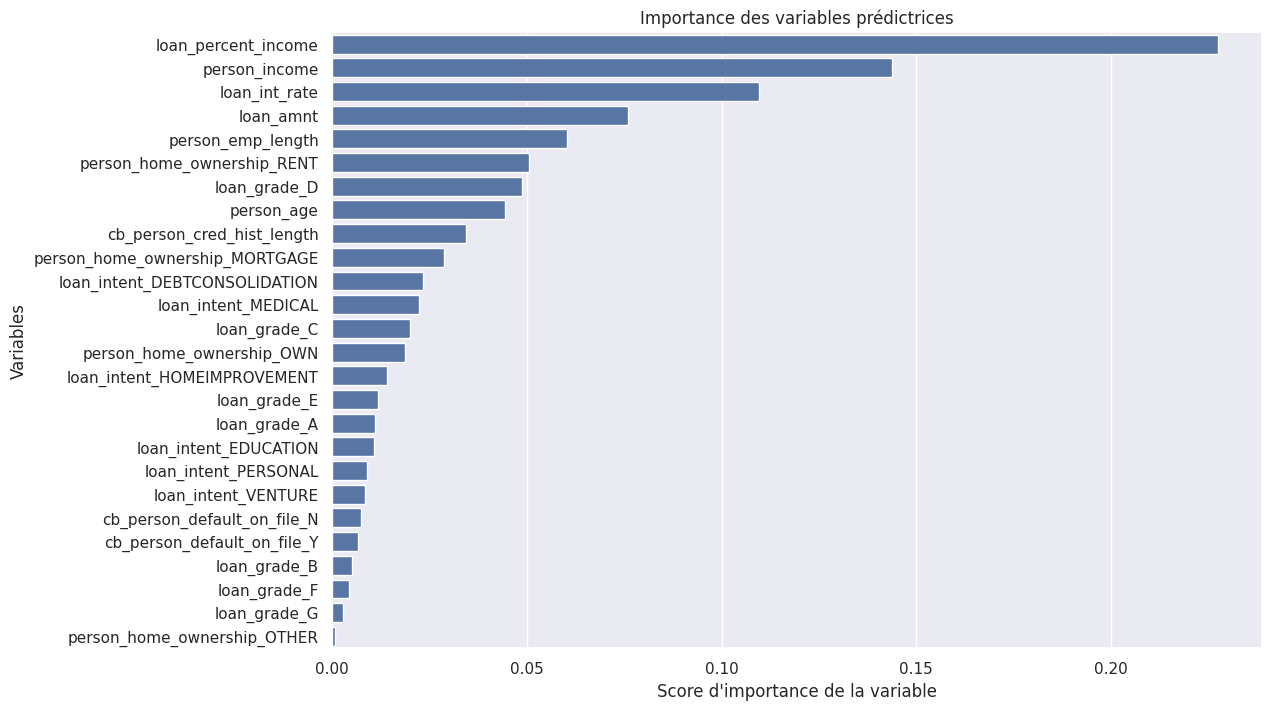

In [35]:
# Visualisation des variables importantes
sns.barplot(x=vars_imp, y=vars_imp.index)
plt.xlabel("Score d'importance de la variable")
plt.ylabel('Variables')
plt.title("Importance des variables prédictrices")
plt.show()

### (RE)CONSTRUCTION D'UN MODELE DE FORETS ALEATOIRES  

Remodélisons les données en ne considérant cette fois-ci que les variables dont le score d'importance est supérieur à 0,010.  

In [36]:
# variables dont le score d'importance est supérieur à 0,010 (Essayez plusieurs seuils et regardez les valeurs des métriques

vars_selected = vars_imp[vars_imp > 0.010].index.to_list()
vars_selected

['loan_percent_income',
 'person_income',
 'loan_int_rate',
 'loan_amnt',
 'person_emp_length',
 'person_home_ownership_RENT',
 'loan_grade_D',
 'person_age',
 'cb_person_cred_hist_length',
 'person_home_ownership_MORTGAGE',
 'loan_intent_DEBTCONSOLIDATION',
 'loan_intent_MEDICAL',
 'loan_grade_C',
 'person_home_ownership_OWN',
 'loan_intent_HOMEIMPROVEMENT',
 'loan_grade_E',
 'loan_grade_A',
 'loan_intent_EDUCATION']

In [37]:
# Nouvelle division des données
X_train, X_test, y_train, y_test = train_test_split(X[vars_selected], y, stratify = y, test_size = 0.3, random_state = seed)

print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)
print("y_train.shape", y_train.shape)
print("y_test.shape", y_test.shape)

X_train.shape (21760, 18)
X_test.shape (9327, 18)
y_train.shape (21760,)
y_test.shape (9327,)


In [38]:
# Création du modèle
rf2 = RandomForestClassifier(random_state = seed)

# Entraînement du modèle
rf2.fit(X_train, y_train)

# Prédictions
y_pred2 = rf2.predict(X_test)

# Rapport de classification
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7290
           1       0.97      0.73      0.83      2037

    accuracy                           0.93      9327
   macro avg       0.95      0.86      0.89      9327
weighted avg       0.94      0.93      0.93      9327



En ne sélectionnant que les variables indépendantes dont le score d'importance est supérieur à
0,010, les performances du modèle (voir rapport de classification ci-dessus) n'ont pas été
amélioré. Cette opération nous a quand même permise de réduire la complexité du modèle car
nous sommes passés de 26 à 18 variables indépendantes tout en gardant les mêmes
performances qu'avec le premier modèle.

Dans ce qui suit, nous appliquerons la méthode de sous-échantillonnage afin de régler le
problème de déséquilibre de classe.

### METHODE DE SOUS-ECHANTILLONNAGE
Imaginons qu'on ait 100 prêts dont 20 sont en défaut de paiement et 80 ne le sont pas. La méthode de sous-échantillonnage consiste à échantillonner de façon aléatoire 20 prêts nondéfauts
et à les combiner avec les 20 prêts défauts de paiement pour former un ensemble de données équilibré.

In [39]:
# Concaténation de X_train, y_train
df_train = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)

# Nombre de prêts dans chaque classe
n_nondefauts, n_defauts = df_train['loan_status'].value_counts()
print("Nombre de prêts non-défauts :", n_nondefauts)
print("Nombre de prêts en défaut de paiement :", n_defauts)

# dataframe des prêts en défaut et dataframe des prêts en non défauts
defauts_df = df_train[df_train['loan_status'] == 1]
nondefauts_df = df_train[df_train['loan_status'] == 0]

# Souséchantillonnagedes non défauts pour qu'ils soient en même nombre que les défauts
nondefauts_df2 = nondefauts_df.sample(n_defauts)

# Concaténation
df_train2 = pd.concat([nondefauts_df2.reset_index(drop = True), defauts_df.reset_index(drop = True)],axis = 0)

# Vérification du nombre de prêts de chaque classe
df_train2['loan_status'].value_counts()

Nombre de prêts non-défauts : 17008
Nombre de prêts en défaut de paiement : 4752


,count
loan_status,
0,4752
1,4752


Construisons maintenant un modèle de forêts aléatoires sur ce nouvel ensemble de données
sous-échantillonné.

In [40]:
X = df_train2.drop('loan_status', axis = 1)
y = df_train2['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = seed)

# Création du modèle
rf3 = RandomForestClassifier(random_state = seed)

# Entraînement du modèle
rf3.fit(X_train, y_train)

# Prédictions
y_pred3 = rf3.predict(X_test)


# Rapport de classification
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1426
           1       0.89      0.78      0.83      1426

    accuracy                           0.84      2852
   macro avg       0.85      0.84      0.84      2852
weighted avg       0.85      0.84      0.84      2852



Ce rapport de classification indique le modèle rf3 prédit les défauts de paiement de manière
beaucoup plus précise que les précédents modèles. En effet, 78% des prêts en défauts de
paiement ont été correctement prédit contre 73% pour les deux modèles précédents.

## CONCLUSION
Dans ce projet, nous avons traité un problème de classification. De plus, ce projet nous a permis
d’ajouter plusieurs techniques utiles à notre boîte à outils de Machine Learning. Notre objectif était de construire un modèle qui prédit si le débiteur d’une banque sera en défaut de paiement ou pas. Un tel modèle est une véritable aide à la décision et permet aux banques de mieux gérer le risque de crédit.  

Comment rechercher les hyperparamètres optimaux d’un modèle ? Ce sera l’objet principal du prochain projet.